In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from utils import create_directory
from plot import plot_learning
import matplotlib.pyplot as plt

In [2]:
data_dir = create_directory(directory_name='loss0')
ignore = [2,3,7,13]

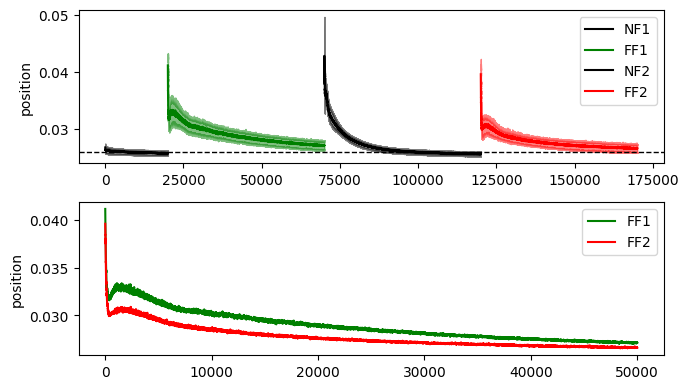

In [3]:
fig, ax = plot_learning(data_dir,num_model=16,w=1,phases=['NF1','FF1','NF2','FF2'],loss_type='position',figsize=(7,4),ignore=ignore)
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(data_dir,'learning_curve_pos.png'),dpi=300)

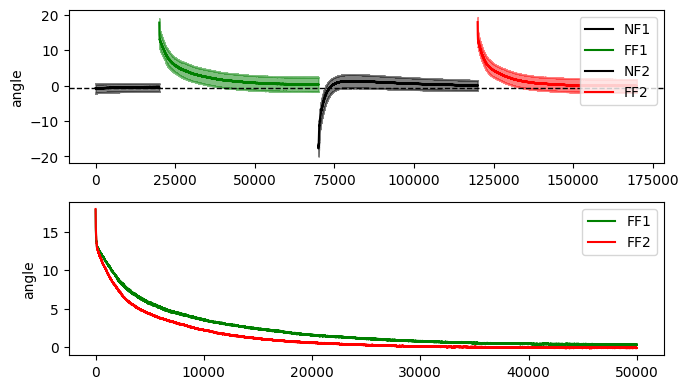

In [4]:
fig, ax = plot_learning(data_dir,num_model=16,w=1,loss_type='angle',figsize=(7,4),ignore=ignore)
plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(data_dir,'learning_curve_ang.png'),dpi=300)

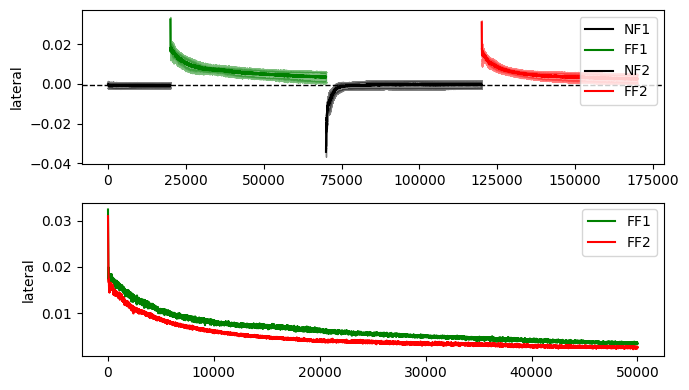

In [5]:
fig, ax = plot_learning(data_dir,num_model=16,w=1,loss_type='lateral',figsize=(7,4),ignore=ignore)
plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(data_dir,'learning_curve_lat.png'),dpi=300)